In [16]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

def read_file(file_name):
    """
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def wandle_datei_um_rev(file, out_name, contig_len):
    out = open(out_name,'w')
    lines = []
    for line in file:
        b, a, dist = line.split()
        
      #  if float(dist) + contig_len[b] + contig_len[a]< 0:
       #     print(a,b,dist)
        dist = float(dist) + contig_len[a]
        if dist < 0:
            a, b = b, a
            dist = - dist
        lines.append(a+'_0\t'+b+'_0\t'+str(dist)+'\n')
       # if a == b:
            #print(a,b,dist)
    lines.sort()
    out.writelines(lines)
    out.close()
    
def wandle_datei_um(file, out_name, contig_len):
    out = open(out_name,'w')
    lines = []
    for line in file:
        a, b, dist = line.split()
        
      #  if float(dist) + contig_len[b] + contig_len[a]< 0:
       #     print(a,b,dist)
        dist = float(dist) + contig_len[a]
        if dist < 0:
            a, b = b, a
            dist = - dist
        lines.append(a+'_0\t'+b+'_0\t'+str(dist)+'\n')
       # if a == b:
            #print(a,b,dist)
    lines.sort()
    out.writelines(lines)
    out.close()
    
def write_file(file_name, data):
    with open(file_name, 'w') as out:
        for a,b,dist in data:
            out.write(a +'\t'+ b +'\t'+str(dist) +'\n')
            
def write_sol(file_name, pos):
    pos = sorted(pos.items(), key = lambda x: x[1])
    with open(file_name, 'w') as out:
        for contig, position in pos:
            out.write(contig +'\t'+ str(position) + '\n')
            
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
            
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)

    return position, contig_repeat
            
def sortiere_repeats(position, contig_repeat):
    
    for contig,repeats in contig_repeat.items():
        if len(repeats) == 1:
            continue
        
        for rep, pos in zip(repeats, sorted([position[rep] for rep in repeats])):
            position[rep] = pos
            
def get_contigs(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
#connected('my_apd200.lst')




def entferne_sackgassen(graph, start = '2345APD_0', ziel = '2080APD_0'):
    änderungen = True
    while änderungen:
        änderungen = False
        for x in list(graph):
            if graph.in_degree[x] == 0 and x != start:
                graph.remove_node(x)
                änderungen = True
            elif graph.out_degree[x] == 0 and x != ziel:
                graph.remove_node(x)
                änderungen = True
                
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName

def plot_graph(position, data, X = set(), von = 250, bis = 400, kantenanzahl = 2, fehler = 1000):
    useIntName = True
    intName = get_intName(position)

    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)

    graph = nx.DiGraph()

    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
       # if {a,b}&{'145APD_1','342APD_0','501APD_3','501APD_1'}:
        #    continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1
        """
        elif abs(real_dist - dist) > 20000:
            color = 'blue'
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
                color = 'red'
            graph.add_edge(a, b, penwidth = 2, color = color)"""
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}

    for b in pp:
        for a in pp[b]:
            #graph.add_edge(intName[a],intName[b],penwidth = 2, label = s[a][b])
            #graph.add_edge(a, b, penwidth = 2, label = s[a][b])
            
            b_name = intName[b]
            a_name = intName[a]
            if useIntName:
                graph.add_edge(a_name,b_name,label = (s[a][b],int(position[b]-position[a])))
            else:
                graph.add_edge(contig_name(a),contig_name(b),label = (s[a][b],int(position[b]-position[a])))
    for a in ss:
        for b in ss[a]:
            #graph.add_edge(intName[a],intName[b],penwidth = 2, label = s[a][b])
            #graph.add_edge(a, b, penwidth = 2, label = s[a][b])

            b_name = intName[b]
            a_name = intName[a]
            if useIntName:
                graph.add_edge(a_name,b_name,label = (s[a][b],int(position[b]-position[a])))
            else:
                graph.add_edge(contig_name(a),contig_name(b),label = (s[a][b],int(position[b]-position[a])))
    evil = set()
    E = set()
    for a in s:
        for c in s[a]:
            E.add((a,c))
            for b in set(s[a]) & set(p[c]):
                evil.add((a,b))
                evil.add((b,c))
    for a,b in E-evil:
        #graph.add_edge(intName[a],intName[b],penwidth = 2,color = 'green', label = s[a][b])
        #graph.add_edge(a, b, penwidth = 2,color = 'green', label = s[a][b])
        b_name = intName[b]
        a_name = intName[a]
        if useIntName:
            graph.add_edge(a_name,b_name,color = 'green', label = (s[a][b],int(position[b]-position[a])))
        else:
            graph.add_edge(contig_name(a),contig_name(b),color = 'green', label = (s[a][b],int(position[b]-position[a])))

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    pydot.write_png('ttt.png')
    display(Image(filename='ttt.png'))
    
def sub(al, bl, dist, tol = 1000):
    k = iter(bl)
    for i in al:
        i += dist
        try:
            e = next(k)
            while e < i - tol:
                e = next(k)
            if e > i + tol:
                return True
        except:
            return True
    return False

def b_dom_a(aneig,bneig,abdist):
    for c, la in aneig.items():
        if sub(la, bneig[c],abdist):
            return False
    return True

def überdeckte(graph):
    neigh = {}
    for b in graph:
        neigh[b] = coll.defaultdict(list)
        for a, l in graph.pred[b].items():
            neigh[b][a] = sorted([-d for d in l])
        neigh[b][b].append(0)
        for c, l in graph.succ[b].items():
            neigh[b][c] += sorted([d for d in l])
        neigh[b] = dict(neigh[b])
        
        
    evil = set()
    
    for a, aneig in neigh.items():
        for b, l in aneig.items():
            
            if len(l) > 1 or a == b:
                continue
                
            bneig = neigh[b]
            if not set(aneig) <= set(bneig):
                continue
                
            abdist = l[0]
            if b_dom_a(aneig,bneig,abdist):
                evil.add(a)
    return evil


def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 1:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil
        
def umsortieren(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
          #  print('not',a, b, dist)
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()

In [21]:
#Umwandlungen von Dateien in einen für meine Zwecke bessere Option, 
# _rev liest den Strang verkehrt herum ein, dadurch kann man eine kontrolllösung aufbauen.

contig_len = get_contig_lengths(open('APDContigs.len'))
print(max(contig_len.values()))
print(min(contig_len.values()))
print(np.std(list(contig_len.values())))
"""
wandle_datei_um_rev(open('apd6.lst'), 'my_apd1999.lst', contig_len)
"""

28764
111
2669.3421180504056


"\nwandle_datei_um_rev(open('apd6.lst'), 'my_apd1999.lst', contig_len)\n"

In [8]:

def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = read_file('my_apd1999.lst') #rückwärts Edition
data2 = read_file('my_apd1998.lst')
data2 = connected(data2)
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
len(data3)

Es gibt unzusammenhängende Regionen in den Daten
99.63% der Contigs sind in der größten Komponente.
len z[x] 143416
len Z[x]  63766
len C     56692
len Z-C    7074
len z-Z   79650


63766

In [62]:

Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0', 'stärke', 'gewicht', 'in_out', 'genauigkeit'])

In [63]:

#start = '2080APD_0'
#ziel = '2345APD_0'

start = '2345APD_0'
ziel = '2080APD_0'

graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
print(len(graph.edges()))
entferne_sackgassen(graph, start = start, ziel = ziel)
graph2 = nx.MultiDiGraph() 
for d, a, b, g in data3:
    if a != b:
        graph2.add_edge(a,b,d, gewicht = g)
entferne_sackgassen(graph2, start = start, ziel = ziel)

#evil = singels(graph)
#graph.remove_nodes_from(evil)
#graph2.remove_nodes_from(evil)
print(len(graph2.edges()))


#evil = überdeckte(graph2)
#graph.remove_nodes_from(evil)
#graph2.remove_nodes_from(evil)

aktuell = start
position = {}
pre_position = {aktuell : 0}
constr_pos = coll.defaultdict(list)
constr_pos[aktuell] = [0]
#besucht = []
def gruppiert2(werte, min_abstand):
    werte.sort()
    
    previous = werte[0]
    current_group = []
    max_len = 0
    for current in werte:
        if current - previous > min_abstand:
            
            this_len = len(current_group)
            if this_len > max_len:
                max_group = current_group[this_len//2]
                max_len = this_len
                
            current_group = []
            
        current_group.append(current)
        previous = current
        
    this_len = len(current_group)
    if this_len > max_len:
        max_group = current_group[this_len//2]
        max_len = this_len
        
    return max_group

def aa(constr_pos):
    return min(
        (gruppiert2(constr_pos[contig], 500),contig) 
        for contig in constr_pos 
    )

        
def bb (graph,graph2,position,constr_pos,aktuell,pos):
    for contig, dists in graph.succ[aktuell].items():
        for dist in dists:
            if not contig in position:
                constr_pos[contig].append(pos + dist)
            elif not aktuell in position and contig in graph2[aktuell]:
                d = min(list(graph2[aktuell][contig]), key = lambda d: abs(d-dist))
                g = graph2[aktuell][contig][d]['gewicht']
                if g>2 and pos + dist - position[contig] > 10000:
                    constr_pos[contig].append(pos + dist)
            
def cc(constr_pos):
    return {
        contig: gruppiert2(constr_pos[contig], 500)
        for contig in constr_pos 
    }


def dd3(graph, pre_position):
    subgraph = nx.DiGraph()
    subgraph.add_nodes_from(pre_position)
    subgraph.add_edges_from(
        {
            (a,b) 
            for a, pa in pre_position.items()
            for a, b, d in graph.edges(a, keys = True) 
            if b in pre_position and pre_position[b] > pa and -1000 <= pre_position[b] - pa - d <= 1000 
            #-450 - 0.0025*d <= pre_position[b] - pa - d <= 450  + 0.0025*d
        }
    )
    subgraph.add_edges_from(
        {
            (a,b) 
            for a, pa in pre_position.items()
            for b, a, d in graph.in_edges(a, keys = True) 
            if b in pre_position and pre_position[b] > pa and pre_position[b] - pa + d <= 1000 
            #-450 - 0.0025*d <= pre_position[b] - pa - d <= 450  + 0.0025*d
        }
    )
    return subgraph
def dd4(graph, pre_position):
    subgraph = nx.DiGraph()
    subgraph.add_nodes_from(pre_position)
    subgraph.add_edges_from(
        {
            (a,b) 
            for a, pa in pre_position.items()
            for a, b, d, g in graph.edges(a, keys = True, data = 'gewicht') 
            if g > 1 and b in pre_position and pre_position[b] > pa and -1000 <= pre_position[b] - pa - d <= 1000
            #-450 - 0.0025*d <= pre_position[b] - pa - d <= 450  + 0.0025*d
        }
    )
    return subgraph
def get_grad0(graph, pre_position):
    grad0 = set()
    for b, pb in pre_position.items():
        h = True
        for a, b, d in graph.in_edges(b, keys = True):
            if a in pre_position and pre_position[a] < pb and -1000 <= pb - pre_position[a] - d <= 1000:
                h = False
                break
        if h:
            for b, a, d in graph.out_edges(b, keys = True):
                if a in pre_position and pre_position[a] < pb and pb - pre_position[a] + d <= 1000:
                    h = False
                    break
            if h:
                grad0.add(b)
    return grad0


def entferne_zukleine_positionen(constr_pos, pos):
    for c in constr_pos.copy():
        for p in constr_pos[c].copy():
            if p < pos - 500:
                constr_pos[c].remove(p)
            if not constr_pos[c]:
                print('contig wurde übersprungen', c)
                constr_pos.pop(c)
def solve(graph, graph2, position, constr_pos, rr = [], i=[], repeats = [], aktuell = '', old = 0):
    while constr_pos:
        
        aktuell_s = aktuell
        pos, aktuell = aa(constr_pos)
        
        constr_pos.pop(aktuell)
        
        anti = set()
        h = True
        for a,b,d,g in graph2.in_edges(aktuell, keys = True, data = 'gewicht'):
            if a not in position:
                anti.add(a)
                continue
            if g > 1 and -2000 <= pos - position[a] - d <= 2000:
                h = False
                break
        if not (h and len(anti) >= 3):
            entferne_zukleine_positionen(constr_pos, pos)
            # aktualisiere constr_pos
            bb(graph, graph2, position, constr_pos, aktuell, pos)

            if aktuell in position:
                repeats = repeats + [(aktuell, position[aktuell])]
            position[aktuell] = pos
        else:
            aktuell = aktuell_s
        
        pre_position = cc(constr_pos)
        
        #subgraph2 = dd3(graph2, pre_position)
        #grad0 = {a for a in subgraph2 if subgraph2.in_degree[a] == 0}
        grad0 = get_grad0(graph2, pre_position)
        if len(grad0) > 1:
            #print(aktuell)
            subgraph2 = dd3(graph2, pre_position)
            hl = len(grad0)
            grad0 = {
                b 
                for b in grad0 if b in graph[aktuell]
                for d in graph[aktuell][b] if abs(pre_position[b] - position[aktuell] - d) < 1000
            }
            if len(grad0) == 0:
                print('kein geeigneter Nachfolger gefunden.')
                return []
            rr.append(aktuell)
          ##  print('-',aktuell)
            komponenten = [set(nx.predecessor(subgraph2, start)) for start in grad0]
            
            count_nodes = sum((coll.Counter(kompon) for kompon in komponenten), coll.Counter())
            komponenten_2 = [{a for a in kompon if count_nodes[a] == 1} for kompon in komponenten]
            mini_k = [(g0,k) for g0, k, k2 in zip(grad0, komponenten, komponenten_2) if len(k2) == 1]
            evil = set()
            for (sa,ka), (sb,kb) in it.combinations(mini_k,2):
                if len(ka) > 1 and ka-{sa} == kb-{sb}:
                    sa_repeat = sa in position 
                    sb_repeat = sb in position 
                    h = False
                    if sa_repeat and not sb_repeat:
                        h = sa
                        evil.add(sa)
                        continue
                    if sb_repeat and not sa_repeat:
                        h = sb
                        evil.add(sb)
                        continue
                    preds_a = { a
                                for a,l in graph2.pred[sa].items() if a in position
                                for d in l if abs(pre_position[sa] - position[a] - d) < 1000 }
                    preds_b = { a
                                for a,l in graph2.pred[sb].items() if a in position
                                for d in l if abs(pre_position[sb] - position[a] - d) < 1000 }
                    if len(preds_a) > len(preds_b):
                        evil.add(sb)
                    else:
                        evil.add(sa)
                        
            if len(evil)>0:
                grad0 -= evil
            komponenten = [set(nx.predecessor(subgraph2, start)) for start in grad0]
            count_nodes = sum((coll.Counter(kompon) for kompon in komponenten), coll.Counter())
            komponenten = [{a for a in kompon if count_nodes[a] == 1} for kompon in komponenten]

            komponenten = [
                (
                    {
                        a
                        for b in komponente
                        for a,l in graph2.pred[b].items() if a in position
                        for d in l if abs(pre_position[b] - position[a] - d) < 1000
                    }, 
                    komponente)
                for komponente in komponenten
            ]
        
            
            s = komponenten[0][0].copy()
            for pro, _ in komponenten[1:]:
                s &= pro
            try:
                min_s = min(position[x] for x in s)
            except:
                print('kein Schnitt')
                min_s = pos
              
            komponenten = [[{p for p in pro if position[p] < min_s}, k] for pro, k in komponenten]
            komponenten = sorted([[len(pro),sorted([position[x] for x in pro]),k] for pro, k in komponenten],reverse=True)
            
            kk = [min(k,key = lambda x: pre_position[x]) for _,_,k in komponenten]
            
            G = graph.subgraph(set(graph)-set(position))
            if len(komponenten) > 1 and not komponenten[1][0]*2+1 <= komponenten[0][0]:
                for (a,ka), (b,kb) in it.combinations(zip(kk,komponenten),2):
                    if ka in komponenten and kb in komponenten:
                        if a not in G or b not in G:
                            continue
                        ab = nx.has_path(G,a,b)
                        ba = nx.has_path(G,b,a)
                        if ab and not ba:
                            komponenten.remove(kb)
                        elif ba and not ab:
                            komponenten.remove(ka)
                # Eine weitere Möglichkeit: werfe Stränge raus, die nur eingehende Kanten mit Gewicht 1 haben,
                # wenn es andere Stränge mit eingehenden Kanten mit Gewicht 3 oder größer gibt. liefert nichts falsches
                # aber die Arbeit ist auch so schon lang genug. 
                # Bei der Rückwärtsedition hat man damit ein Choicepoint weniger.
                """
                KA = komponenten[0]
                nachfolger = {x for _,_,k in komponenten for x in k}
                el_set = {x:j for j,(_,_,k) in enumerate(komponenten) for x in k}
                wert = {j: 0 for j in range(len(komponenten))}
                for b in nachfolger:
                    for a,b,d,g in graph2.in_edges(b, keys = True, data = 'gewicht'):
                        if a in position and -1000 <= pre_position[b] - position[a] - d <= 1000:
                            wert[el_set[b]] = max(wert[el_set[b]], g)
                if max(wert.values()) >= 3:
                    h = False
                    for j, w in sorted(wert.items(),reverse = True):
                        if w <= 1:
                            komponenten.remove(komponenten[j])
                            h = True
                    if h and komponenten[0] != KA:
                        print('KA: ', KA)
                        print('K:  ', komponenten[0])

                       # print(len(komponenten))
                        #print(komponenten[1][0], komponenten[0][0])
                        p = position.copy()
                        pp = pre_position.copy()
                        p.update(pp)

                        A = {i for a,b,d in data2 if a in p and b in pp and -500 < p[b] - p[a] -d < 500 for i in [a,b] }
                       # plot_graph(p,[[a,b,d] for a,b,d in data2 if a in A and b in A],X = set(grad0),kantenanzahl=2, bis = 3000,fehler = 1000)
               #     komponenten[0] = KA
               """  
            if len(komponenten) == 1 or (komponenten[1][0]*2+1 <= komponenten[0][0]):
                
              #  print('U',len(position),aktuell)#,intName[aktuell])
                
                komponente = komponenten[0][2]
                
                ##print(aktuell)
                ##p = position.copy()
                ##pp = pre_position.copy()
                ##p.update(pp)
                ##A = {i for a,b,d in data2 if a in p and b in pp and -2000 < p[b] - p[a] -d < 2000 for i in [a,b] }
                ##plot_graph(p,[[a,b,d] for a,b,d in data2 if a in A and b in A],X = set(pp), bis = 3000,fehler = 1000)
                
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k] for k in komponente})
                pos, start = aa(constr_pos_komp)
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k] for k in  set(nx.predecessor(subgraph2, start))})
                
                entferne_zukleine_positionen(constr_pos_komp, pos)
                
              ###   intName = get_intName(p)
              ###  for x in sorted(constr_pos_komp, key = lambda x: constr_pos_komp[x][0])[:3]:
              ###      print(intName[x])
                return solve(graph,graph2,position,constr_pos_komp,rr,i,repeats,aktuell,old)
            
            """print('s', s)
            print('anz', len(komponenten))
            print(komponenten[0][0],komponenten[1][0])
            print(komponenten[0][1][:2],komponenten[1][1][:2])
            print(len(komponenten[0][2]),len(komponenten[1][2]))
            print()"""
            erg = []
            index = len(i)
            i.append(len(komponenten))
            for _,_, komponente in komponenten:
                i = i[:index+1]
                i[index] -= 1
                print('T',i,)#intName[aktuell])
                    
                

                print(len(komponenten))
                print(komponenten[1][0], komponenten[0][0])
                p = position.copy()
                pp = pre_position.copy()
                p.update(pp)
                
                A = {i for a,b,d in data2 if a in p and b in pp and -500 < p[b] - p[a] -d < 500 for i in [a,b] }
                plot_graph(p,[[a,b,d] for a,b,d in data2 if a in A and b in A],X = set(grad0),kantenanzahl=2, bis = 3000,fehler = 1000)

                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k] for k in komponente})
                _, start = aa(constr_pos_komp)
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k].copy()  for k in  set(nx.predecessor(subgraph2, start))})
                #constr_pos_komp = coll.defaultdict(list,{k: [d for d in constr_pos[k] if -1000 < pre_position[k]-d < 1000] for k in  set(nx.predecessor(subgraph2, start))})

               # return solve(graph,graph2,position.copy(),constr_pos_komp,pre_position,i+1)
                entferne_zukleine_positionen(constr_pos_komp, pos)
                
                    
                erg = erg + solve(graph,graph2,position.copy(),constr_pos_komp,rr,i,repeats,aktuell, old)
            ###    if erg:
            ###        return erg
            
            return erg
    l = len(position)
    maxi = position[aktuell]
    print(i,'erg',l,'max',int(maxi),'repeats',len(repeats))
    if maxi > 4800000:
        return [((l,maxi,len(repeats)), position, rr, repeats)]
    return []

subgraph = solve(graph, graph2, position, constr_pos, [], aktuell = start)
cP.run('solve(graph, graph2, position, constr_pos, [], aktuell = "2345APD_0")',sort = 1)


SyntaxError: unexpected EOF while parsing (<ipython-input-63-4fb653e1d196>, line 389)

(-10000, 10000)

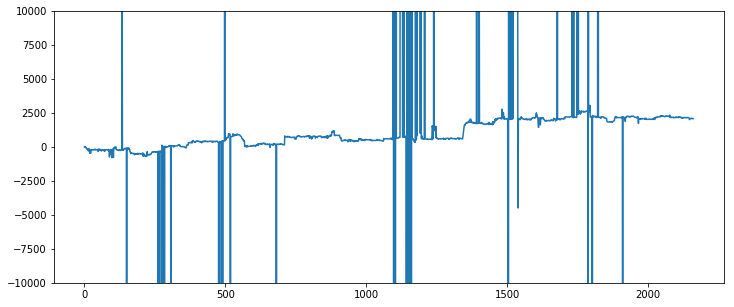

In [52]:

# Plot vorwärts und rückwerts Lösung gegeneinander, Der Unterschied beläuft sich auf unter 2000 Basenpaare.
# Das LP muss also in der Lage sein, kleinere Fehler in dieser Länge zu korregieren.
# Die senkrechten Striche sind Repeats die Unterschiedlich gesetzt wurden. 


plt.rcParams['figure.figsize'] = 12, 5
_,position,_,repeats = deepcopy(subgraph2[0])
contig_rep = {contig_name(rep):[rep] for rep in position }
for r, p in repeats:
    c = contig_name(r)
    r = c + '_' + str(len(contig_rep[c]))
    contig_rep[c].append(r)
    position[r] = p
sortiere_repeats(position,contig_rep)
repeats = {a[:-2] for a,_ in repeats}
intName = get_intName(position)


_,positionY,_,repeatsY = deepcopy(subgraph[3])
maxi = max(positionY.values()) + contig_len['2345APD']
positionY = {p: maxi - contig_len[contig_name(p)] - v for p,v in positionY.items()}
contig_rep = {contig_name(rep):[rep] for rep in positionY }
for r, p in repeatsY:
    c = contig_name(r)
    r = c + '_' + str(len(contig_rep[c]))
    contig_rep[c].append(r)
    positionY[r] = p
sortiere_repeats(positionY,contig_rep)
repeatsY = {a[:-2] for a,_ in repeatsY}
intNameY = get_intName(positionY)


x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if not intName[i] in intNameY:
        continue
    x.append(i)
    a.append(position[intName[i]] - positionY[intName[i]])
plt.plot(x,a,'')
plt.ylim(-10000,10000)

In [9]:

def solve_LP(contigs, constraints, bekannte_positionen = {}):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    position = model.addVars(contigs)
    
    position.update(bekannte_positionen)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in constraints:
        if a in bekannte_positionen and b in bekannte_positionen:
            continue
        eps = model.addVar()
        
        model.addConstr( position[b] - position[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-position[b] + position[a] + dist <= eps) # 
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    
    position.update({contig: position[contig].X for contig in contigs if contig not in bekannte_positionen})
    return position


def solve_LP_standard(positionen, data):
    model = Model()
   # model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(positionen)
    
    model.update()
    
    sorted_pos = sorted(positionen , key = lambda x: positionen[x])
    data = data + [
        (a, b, positionen[b] - positionen[a]) 
        for a, b in zip(sorted_pos[:-1],sorted_pos[1:])
    ]
    # Bedingungen
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - int(dist) <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + int(dist) <= eps) #
        model.addConstr(eps <= 4000) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    print('LP Opt:', model.ObjBound)
    return {cont: contig[cont].X for cont in contig}

def umsortieren(roh_data, repeats, position):
    good_data = []
    bad_data = []
    missing_data = []
    for bedingung in roh_data:
        a, b, dist = bedingung
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if a not in repeats or b not in repeats:
        #    missing_data.append((a+'_0', b+'_0', dist))
         #   continue
            if a in repeats:
                for r_a in repeats[a]:
                    missing_data.append((r_a, b+'_0', dist))
            elif b in repeats:
                for r_b in repeats[b]:
                    missing_data.append((a+'_0', r_b, dist))
            else:
                missing_data.append((a+'_0', b+'_0', dist))
            continue
            
        h = True
        for r_a, r_b in it.product(repeats[a], repeats[b]):
            if -500 <= position[r_b] - position[r_a] - dist <= 500:
                good_data.append((r_a, r_b, dist))
                h = False
        if h:
            for r_a, r_b in it.product(repeats[a], repeats[b]):
                bad_data.append((r_a, r_b, dist))
                
    if missing_data:
        print('Es haben Daten gefehlt')
        
    return good_data, bad_data, missing_data

def ordne_repeats_zu(contig, position, contig_repeats, gruppen):
    repeats = []
    for i, gruppe in enumerate(gruppen):
        contig_version = contig + '_' + str(i)
        repeats += [contig_version]
        position[contig_version] = gruppe.pos
    contig_repeats[contig] = repeats

def get_repeat(constr_pos, min_repeat_abstand = 500, min_güte = 100):
    position = {}
    contig_repeats = {}
    contig_gruppen = {}
    for contig in constr_pos:
        gruppen = gruppierung(constr_pos[contig], min_repeat_abstand, min_güte = min_güte)
        ordne_repeats_zu(contig, position, contig_repeats, gruppen)
        contig_gruppen[contig] = gruppen
    return position, contig_repeats, contig_gruppen




def get_constr_pos(roh_data, position, contig_repeat):
    constr_pos = coll.defaultdict(list)
    intName = get_intName(position)
    for a in position:
        a = contig_name(a)
        for rep_a in contig_repeat[a]:
            constr_pos[a].append((position[rep_a], intName[rep_a], 'self', True))
    for a, b, dist in roh_data:
        for rep_b in contig_repeat[b]:
            constr_pos[a].append((position[rep_b] - dist, intName[rep_b], 'out', len(contig_repeat[b])>1))
        for rep_a in contig_repeat[a]:
            constr_pos[b].append((position[rep_a] + dist, intName[rep_a], 'in', len(contig_repeat[a])>1))
    return dict(constr_pos)


def extrahiere_daten(gruppe):
    gruppe, [A,B,C], counter, direction = gruppe
    max_kantengewicht = counter.most_common(1)[0][1]
    anzahl = len(gruppe)
    stärke = anzahl
    in_out = (B-A) <= C+1
    genauigkeit = 150 / (100+np.std(gruppe))
    
    if max_kantengewicht <= 2 or not in_out or stärke <= 0:
        güte = 0
    else:
        güte = stärke * np.log2(max_kantengewicht) * genauigkeit
    
    güte_0 = anzahl * (np.log2(max_kantengewicht) + 0.5) * (0.5*in_out + 0.5) * genauigkeit

    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = güte_0,
        stärke = stärke,
        gewicht = max_kantengewicht,
        in_out = in_out,
        genauigkeit = genauigkeit
    )
def gruppierung(positionen, min_abstand, min_güte = 100):#TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],[0,3000,0],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction, is_repeat in sorted_pos:
        
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],[0,3000,0],coll.Counter(),set()]
        
        current_group[0].append(current)
        if direction == 'in':
            current_group[1][0] = max(current_group[1][0], contig)
        elif direction == 'out':
            current_group[1][1] = min(current_group[1][1], contig)
        elif direction == 'self':
            current_group[1][2] = 1
        current_group[2][contig] += 1
        current_group[3].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse = True)
    
    if repeat_daten[0].güte < min_güte:
        gruppe = max(repeat_daten, key = lambda x: x.güte_0)
       # if gruppe.güte_0 < min_güte_0:
        #    return []
        return [gruppe]
    return sorted([gruppe for gruppe in repeat_daten if gruppe.güte >= min_güte], key = lambda gruppe: gruppe.pos)


In [57]:
pos_s = position.copy()

In [58]:
feste_position = pos_s.copy()

55 repeats zu Beginn
Es haben Daten gefehlt
23 repeats danach

1. Durchlauf, güte = 300
Academic license - for non-commercial use only
max 4898262.626594093
*
mean 6017.0
100: % 0.7482417476130602
500: % 0.9316803227723046
2000:% 0.9651942022577481
Optimize a model with 236631 rows, 81017 columns and 552139 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 2.98s
Presolved: 81017 rows, 236631 columns, 552139 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.712e+05
 Factor NZ  : 6.706e+05 (roughly 130 MBytes of memory)
 Factor Ops : 1.176e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.15498000e+07  1.00000000e+03  1.0

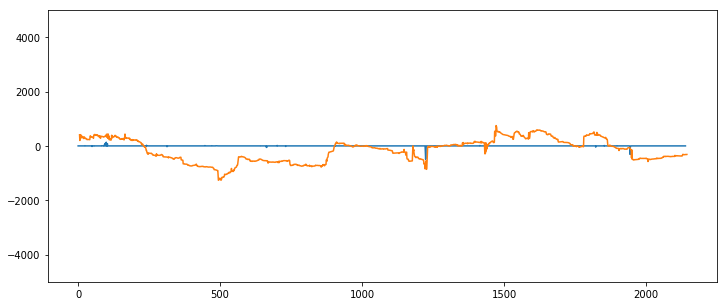


2. Durchlauf, güte = 250.0
max 4897744.0
*
mean 6020.0
100: % 0.6818345423334625
500: % 0.9243936541336729
2000:% 0.9632593166842018
anzahl neuer Repeats: 4
anzahl gelöschter Repeats: 1
anz Repeats: 20
ordne neu


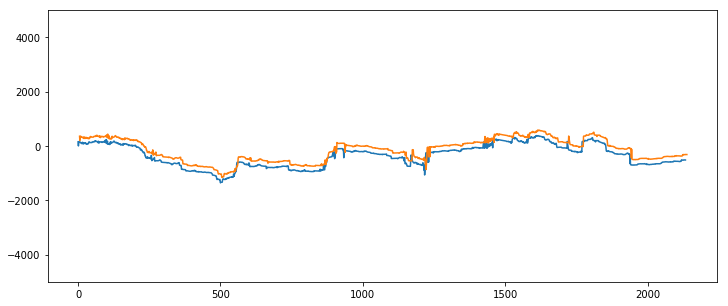


3. Durchlauf, güte = 240.3846153846154
max 4897744.0
*
mean 5936.0
100: % 0.7106705652212982
500: % 0.9282776545078766
2000:% 0.9637517367231404
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 1
anz Repeats: 20
ordne neu


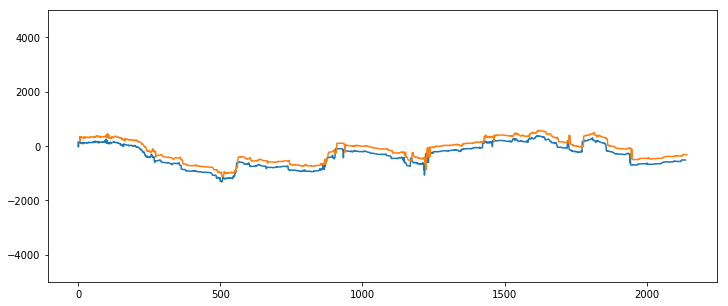


4. Durchlauf, güte = 207.2281167108753
max 4897744.0
*
mean 5958.0
100: % 0.7210036545516093
500: % 0.9294374477551105
2000:% 0.96321268937693
anzahl neuer Repeats: 5
anzahl gelöschter Repeats: 0
anz Repeats: 25
ordne neu


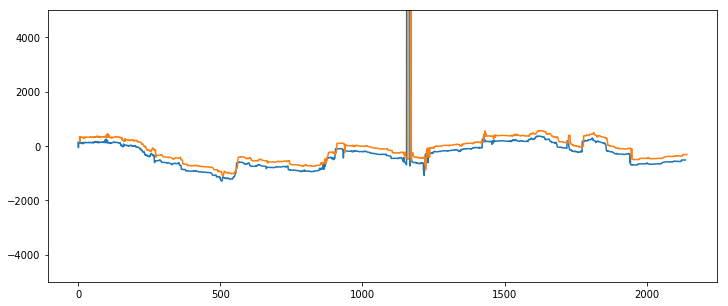


5. Durchlauf, güte = 207.2281167108753
max 4897744.0
*
mean 5846.0
100: % 0.7251595102603897
500: % 0.9332160717365063
2000:% 0.9660010346611485
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 1
anz Repeats: 25
ordne neu


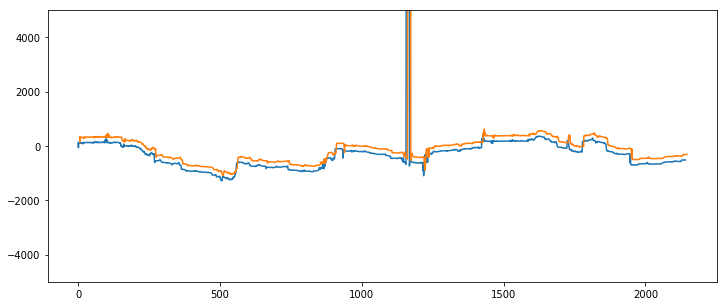


6. Durchlauf, güte = 178.6449281990304
max 4897744.0
*
mean 5844.0
100: % 0.7261227333236769
500: % 0.9339982480462957
2000:% 0.9660162366103144
Optimize a model with 237051 rows, 81159 columns and 553119 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 3.15s
Presolved: 81159 rows, 237051 columns, 553119 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.715e+05
 Factor NZ  : 6.722e+05 (roughly 130 MBytes of memory)
 Factor Ops : 1.180e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.16058000e+07  1.00000000e+03  1.00e-01 9.67e+02  3.15e+03     4s
   1  -5.19498131e+07  6.12111789e+03  6.91e-13 2.18e+03  3.52e+02     

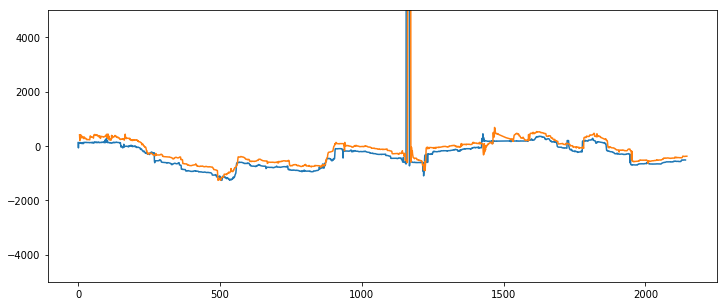


7. Durchlauf, güte = 165.41197055465776
max 4897680.0
*
mean 5858.0
100: % 0.6854490485995854
500: % 0.9263189791125772
2000:% 0.9650085739668198
anzahl neuer Repeats: 3
anzahl gelöschter Repeats: 0
anz Repeats: 30
ordne neu


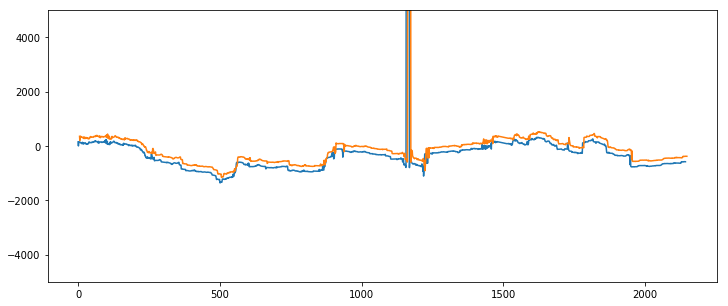


8. Durchlauf, güte = 153.15923199505346
max 4897680.0
*
mean 5837.0
100: % 0.7139907925431986
500: % 0.9306068801310239
2000:% 0.9662806141057138
anzahl neuer Repeats: 3
anzahl gelöschter Repeats: 0
anz Repeats: 33
ordne neu


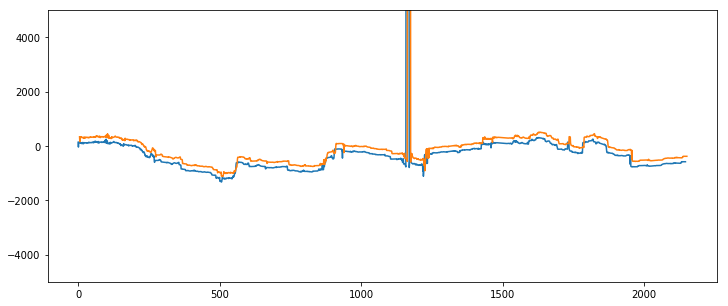


9. Durchlauf, güte = 141.81410369912356
max 4897680.0
*
mean 5792.0
100: % 0.7246604078544654
500: % 0.933924825475429
2000:% 0.9680594243268338
anzahl neuer Repeats: 3
anzahl gelöschter Repeats: 0
anz Repeats: 36
ordne neu


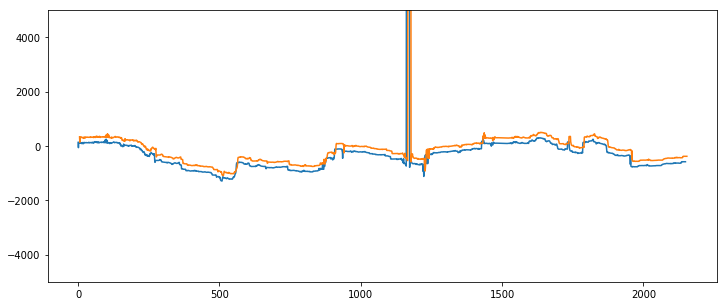


10. Durchlauf, güte = 131.30935527696624
max 4897680.0
*
mean 5748.0
100: % 0.7272239901576021
500: % 0.9362581017643461
2000:% 0.9687751300749864
anzahl neuer Repeats: 3
anzahl gelöschter Repeats: 0
anz Repeats: 39
ordne neu


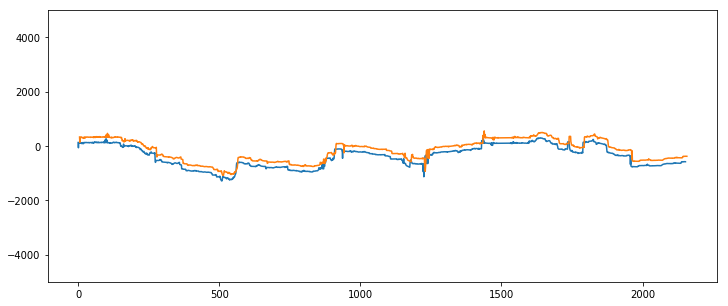


11. Durchlauf, güte = 121.58273636756132
max 4897680.0
*
mean 5772.0
100: % 0.7287030932366354
500: % 0.93844431624636
2000:% 0.9703244327234767
Optimize a model with 238995 rows, 81821 columns and 557655 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 3.06s
Presolved: 81821 rows, 238995 columns, 557655 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.729e+05
 Factor NZ  : 6.747e+05 (roughly 130 MBytes of memory)
 Factor Ops : 1.182e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.18650000e+07  1.00000000e+03  1.00e-01 9.67e+02  3.15e+03     4s
   1  -5.23759918e+07  6.12116976e+03  7.88e-13 2.18e+03  3.52e+02     

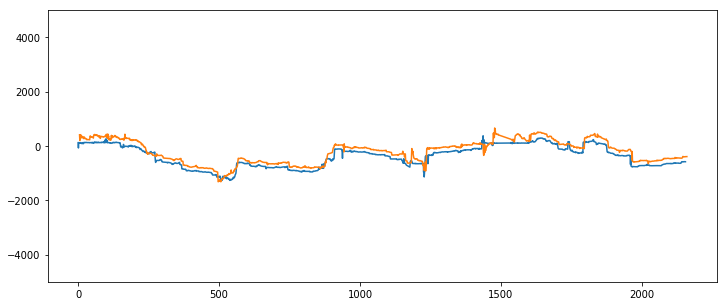


12. Durchlauf, güte = 121.58273636756132
max 4897666.0
*
mean 5981.0
100: % 0.6886313322047142
500: % 0.9305762126373363
2000:% 0.9700618912824449
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
anz Repeats: 45
ordne neu


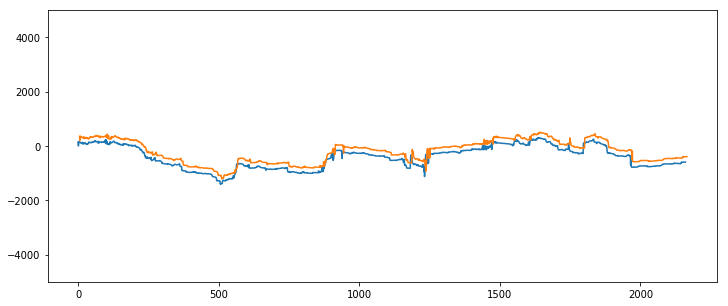


13. Durchlauf, güte = 104.81270376513906
max 4897666.0
*
mean 5965.0
100: % 0.7160377035132819
500: % 0.9346426735218509
2000:% 0.9707489288774636
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
anz Repeats: 46
ordne neu


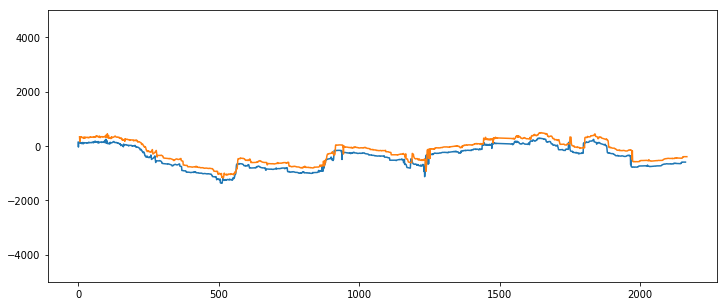


14. Durchlauf, güte = 90.35577910787849
max 4897666.0
*
mean 5935.0
100: % 0.7260100231038714
500: % 0.9365911848789618
2000:% 0.9709659063641911
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
anz Repeats: 47
ordne neu


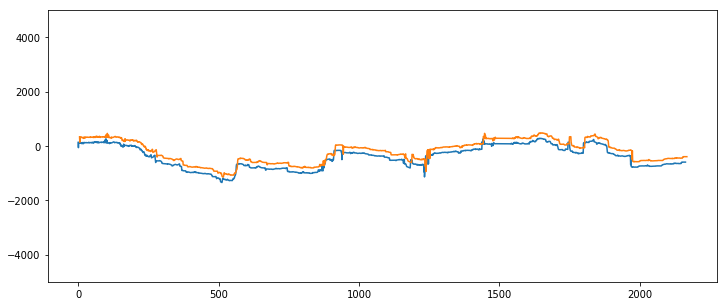


15. Durchlauf, güte = 77.89291302403318
max 4897666.0
*
mean 5929.0
100: % 0.7279744440483699
500: % 0.938173517233815
2000:% 0.971043900298884
anzahl neuer Repeats: 0
anzahl gelöschter Repeats: 0
anz Repeats: 47
ordne neu


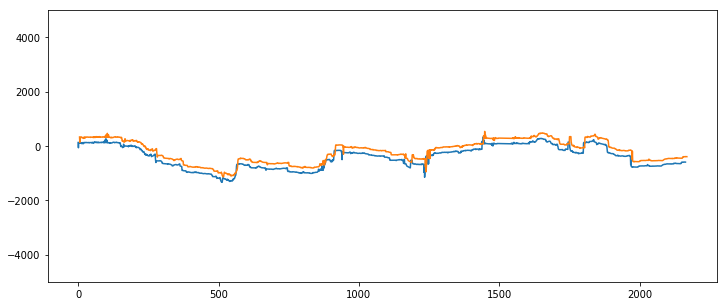


16. Durchlauf, güte = 64.91076085336098
max 4897666.0
*
mean 5925.0
100: % 0.7285609493579768
500: % 0.9389718030808888
2000:% 0.9710969581879383
Optimize a model with 239817 rows, 82103 columns and 559573 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 2.62s
Presolved: 82103 rows, 239817 columns, 559573 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.735e+05
 Factor NZ  : 6.795e+05 (roughly 140 MBytes of memory)
 Factor Ops : 1.192e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.19746000e+07  1.00000000e+03  1.00e-01 9.67e+02  3.15e+03     3s
   1  -5.25562258e+07  6.12120273e+03  7.87e-14 2.18e+03  3.52e+02    

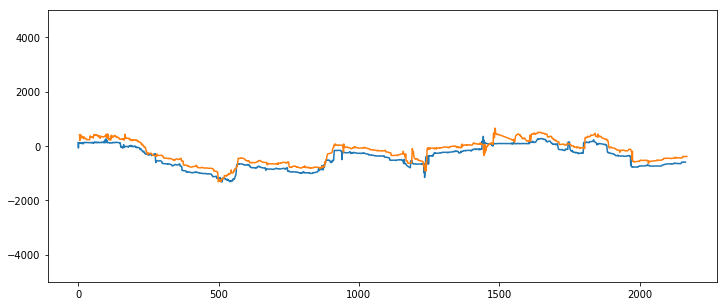


17. Durchlauf, güte = 55.957552459793945
max 4897672.0
*
mean 5841.0
100: % 0.6889728996733168
500: % 0.9309034127098272
2000:% 0.9704820803627074
anzahl neuer Repeats: 3
anzahl gelöschter Repeats: 0
anz Repeats: 51
ordne neu


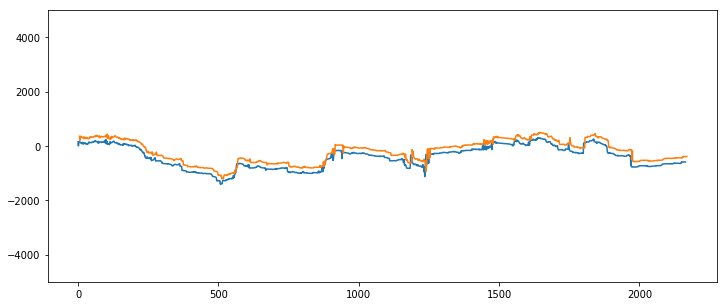


18. Durchlauf, güte = 51.81254857388328
max 4897672.0
*
mean 5344.0
100: % 0.7167797190818773
500: % 0.9356012332990751
2000:% 0.9717711545049674
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
anz Repeats: 52
ordne neu


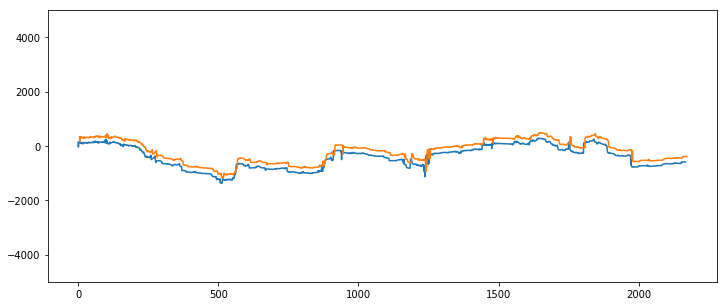


19. Durchlauf, güte = 44.66599014989937
max 4897672.0
*
mean 5324.0
100: % 0.7267482098194402
500: % 0.9376092095796074
2000:% 0.9719875286942817
anzahl neuer Repeats: 5
anzahl gelöschter Repeats: 0
anz Repeats: 57
ordne neu


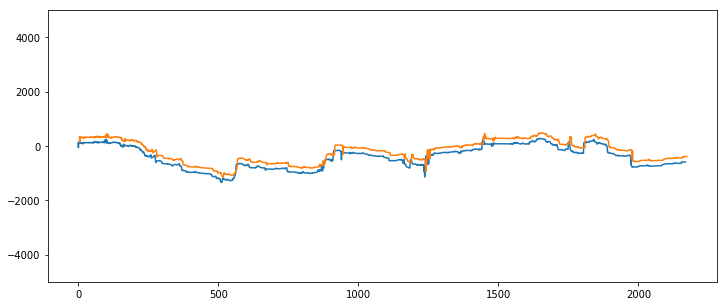


20. Durchlauf, güte = 44.66599014989937
max 4897672.0
*
mean 4897.0
100: % 0.7287623769155973
500: % 0.939440419616812
2000:% 0.9723633574822991
anzahl neuer Repeats: 2
anzahl gelöschter Repeats: 0
anz Repeats: 59
ordne neu


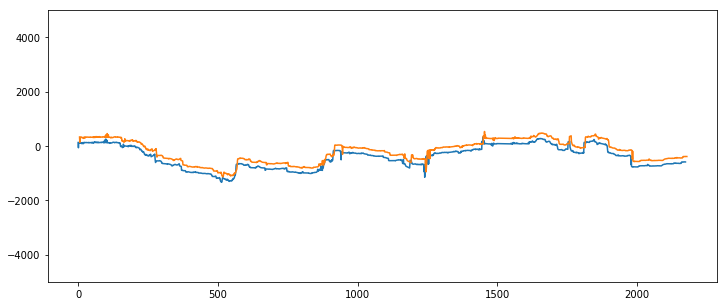


21. Durchlauf, güte = 39.880348348124436
max 4897672.0
*
mean 4942.0
100: % 0.7293416288508792
500: % 0.9401518107088834
2000:% 0.9722250740915656
Optimize a model with 240675 rows, 82401 columns and 561575 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 2.89s
Presolved: 82401 rows, 240675 columns, 561575 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.741e+05
 Factor NZ  : 6.830e+05 (roughly 140 MBytes of memory)
 Factor Ops : 1.199e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.20890000e+07  1.00000000e+03  1.00e-01 9.67e+02  3.15e+03     4s
   1  -5.27442852e+07  6.12121364e+03  3.06e-13 2.18e+03  3.52e+02   

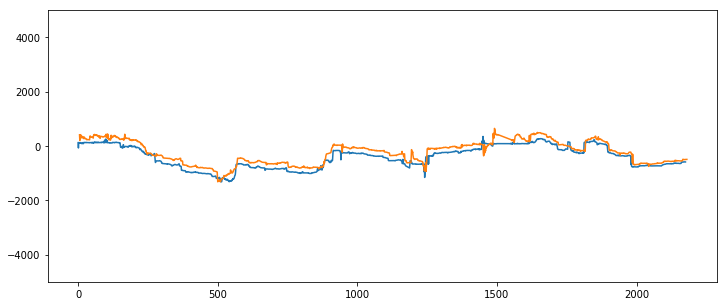


22. Durchlauf, güte = 34.37961064493486
max 4897563.0
*
mean 5127.0
100: % 0.6890208891562312
500: % 0.931987204024717
2000:% 0.971229561983923
anzahl neuer Repeats: 2
anzahl gelöschter Repeats: 0
anz Repeats: 62
ordne neu


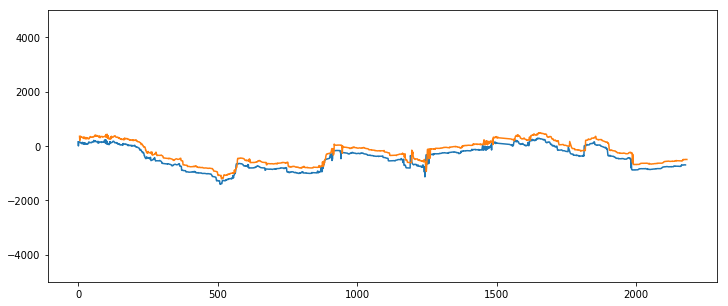


23. Durchlauf, güte = 30.696080932977548
max 4897563.0
*
mean 5056.0
100: % 0.7168468339110993
500: % 0.9358850758616917
2000:% 0.9719185247482103
anzahl neuer Repeats: 2
anzahl gelöschter Repeats: 0
anz Repeats: 64
ordne neu


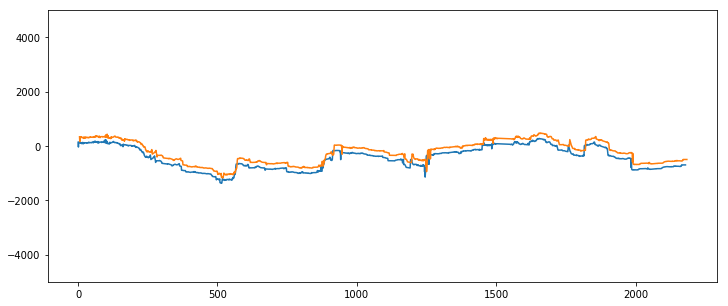


24. Durchlauf, güte = 27.40721511872995
max 4897563.0
*
mean 5077.0
100: % 0.7270017909141865
500: % 0.9376256032373166
2000:% 0.9719674080960258
anzahl neuer Repeats: 0
anzahl gelöschter Repeats: 0
anz Repeats: 64
ordne neu


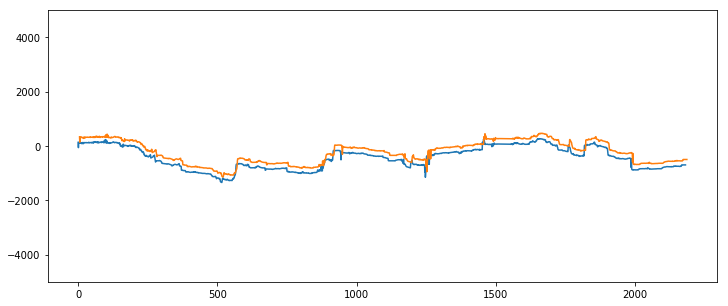


25. Durchlauf, güte = 22.83934593227496
max 4897563.0
*
mean 5132.0
100: % 0.7291816187175754
500: % 0.9383531213047074
2000:% 0.9712578861388508
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
anz Repeats: 65
ordne neu


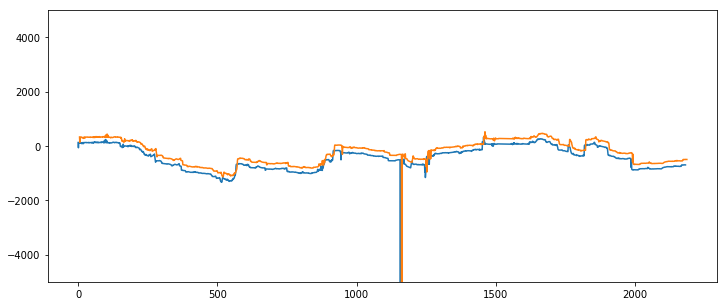


26. Durchlauf, güte = 19.689091320926686
max 4897563.0
*
mean 5142.0
100: % 0.7307902615067051
500: % 0.9391685918554263
2000:% 0.9712793733681462
Optimize a model with 241041 rows, 82530 columns and 562429 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 3.06s
Presolved: 82530 rows, 241041 columns, 562429 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.744e+05
 Factor NZ  : 6.860e+05 (roughly 140 MBytes of memory)
 Factor Ops : 1.205e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.21378000e+07  1.00000000e+03  1.00e-01 9.67e+02  3.15e+03     4s
   1  -5.28245119e+07  6.12122559e+03  9.07e-14 2.18e+03  3.52e+02   

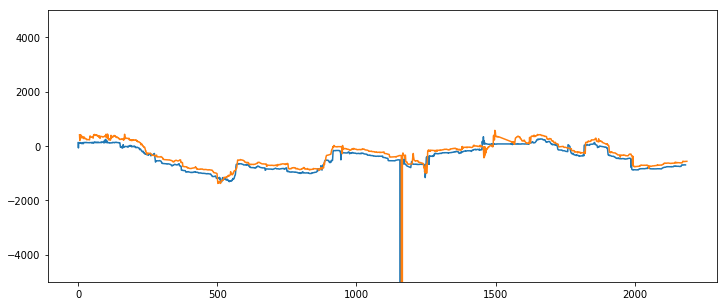


27. Durchlauf, güte = 16.973354587005762
max 4897492.0
*
mean 5106.0
100: % 0.6891309544135222
500: % 0.9319515110124638
2000:% 0.9711251493938876
anzahl neuer Repeats: 3
anzahl gelöschter Repeats: 0
anz Repeats: 69
ordne neu


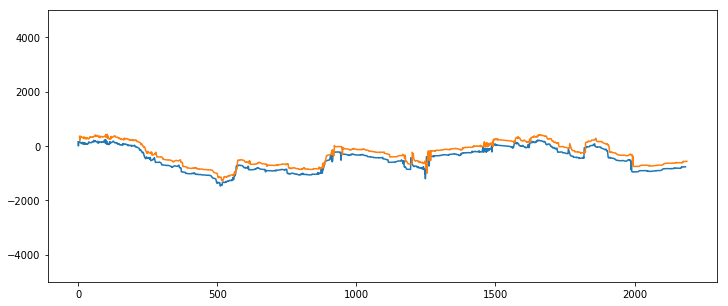


28. Durchlauf, güte = 15.71606906204237
max 4897492.0
*
mean 5091.0
100: % 0.7161517189580417
500: % 0.9353726400600867
2000:% 0.9714383257655935
anzahl neuer Repeats: 0
anzahl gelöschter Repeats: 0
anz Repeats: 69
ordne neu


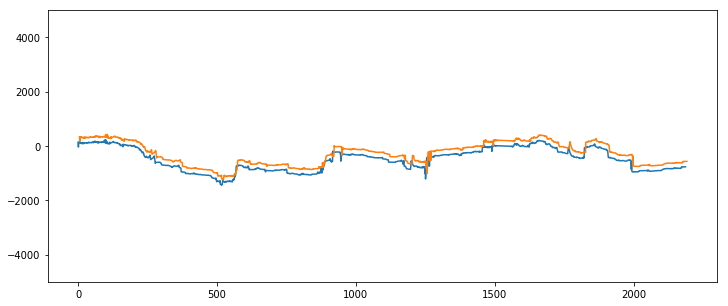


29. Durchlauf, güte = 13.096724218368642
max 4897492.0
*
mean 5151.0
100: % 0.7263645922951917
500: % 0.9363417864995152
2000:% 0.9707962909855654
anzahl neuer Repeats: 0
anzahl gelöschter Repeats: 0
anz Repeats: 69
ordne neu


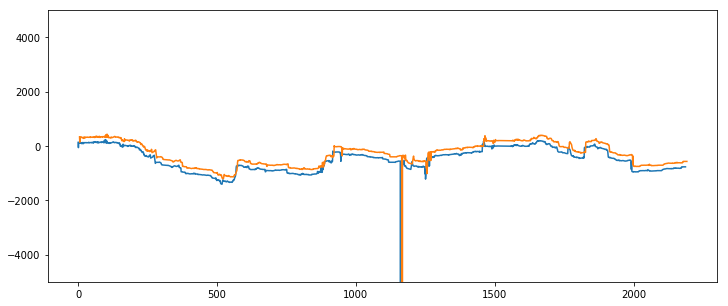


30. Durchlauf, güte = 10.913936848640535
max 4897492.0
*
mean 5340.0
100: % 0.7283664022067158
500: % 0.937649356146987
2000:% 0.9706886427878904
anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
anz Repeats: 70
ordne neu


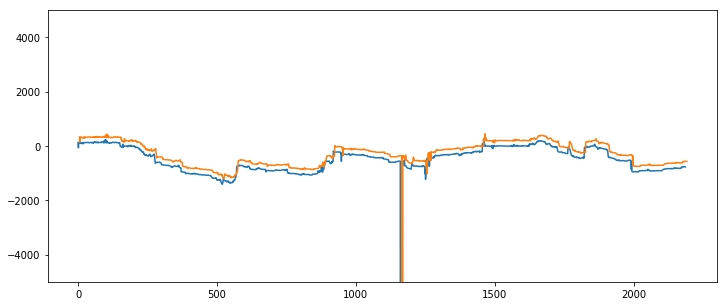


31. Durchlauf, güte = 10
max 4897492.0
*
mean 5273.0
100: % 0.730427064486396
500: % 0.9391868364455672
2000:% 0.971440275833817
Optimize a model with 241332 rows, 82633 columns and 563108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 2.86s
Presolved: 82633 rows, 241332 columns, 563108 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.746e+05
 Factor NZ  : 6.881e+05 (roughly 140 MBytes of memory)
 Factor Ops : 1.210e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.21766000e+07  1.00000000e+03  1.00e-01 1.06e+03  3.27e+03     4s
   1  -5.31427263e+07  6.24761412e+03  3.80e-13 2.31e+03  3.65e+02     4s
   2  -1.6536

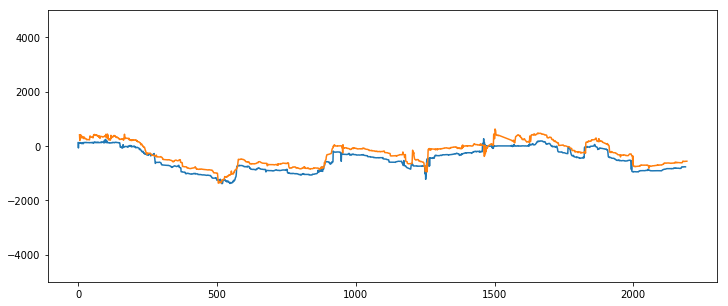

In [69]:

datei = 'my_apd1998.lst'
data = read_file(datei)
G = nx.DiGraph()
for a,b,d in data:
    G.add_edge(a,b)
    
S = set(nx.predecessor(G,'2345APD_0'))
T = set(nx.predecessor(G.reverse(),'2080APD_0'))

schnitt = T&S
data = [
    (a,b,d) 
    for a,b,d in data
    if {a,b} < schnitt
]
data = [
    (a,b,d) 
    for a,b,d in data
    if a != b or d > 1000
]

count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 1:
        abgesichert |= {i,j}
abgesichert |= set(feste_position)


roh_data = [(contig_name(a), contig_name(b), int(d)) for a,b,d in data]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
    

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}

pos = position.copy()
reps = repeats.copy()
rep = contig_repeat.copy()
print(len(repeats),'repeats zu Beginn')

constr_pos = get_constr_pos(roh_data, feste_position, contig_repeat)
position, contig_repeat, gruppen = get_repeat(constr_pos, min_güte = 300)
good_data, bad_data, missing_data = umsortieren(roh_data, contig_repeat, position)
data = good_data + bad_data + missing_data

contigs = get_contigs(data)

for contig in contigs:
    if contig_name(contig) not in contig_repeat:
        contig_repeat[contig_name(contig)] = [contig]
        
        
repeats = {k for k, v in contig_repeat.items() if len(v) > 1}
print(len(repeats), 'repeats danach')

min_güte = 300
untere_schranke = 10
ii = 0
while min_güte >= untere_schranke:
    ii += 1
    print()
    print(str(ii)+'. Durchlauf, güte =', min_güte)
    
    sicher = set()
    for a, G in gruppen.items():
        for i,g in enumerate(G):
            if g.güte_0 > min(50, min_güte):
                sicher.add(contig_repeat[a][i])
                
    feste_position = {contig: pos for contig, pos in position.items() if contig in sicher}
    
    if len(position) != len(feste_position):
        position = solve_LP(get_contigs(data), data, feste_position)
    
    intName = get_intName(position)
    x = []
    a = []
    for i in range(3000):
        if not i in intName:
            break
        c = contig_name(intName[i])
        if c in reps|repeats:
            continue
        x.append(i)
        a.append(position[intName[i]] - pos[intName[i]])
    plt.plot(x,a,)
    plt.ylim(-5000,5000)
    
    print('max', max(position.values()))
    print('*')
    print('mean', sum([abs(position[b] - position[a] -d) for a,b,d in data])//len(data))
    good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
    data = good_data + bad_data
    
    print('100: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 100])/len(data))
    print('500: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 500])/len(data))
    print('2000:%', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 2000])/len(data))
    if ii % 5 == 1 or min_güte == untere_schranke:
        tol = 2000
        s = coll.defaultdict(coll.Counter)
        p = coll.defaultdict(coll.Counter)

        for a, b, dist in data:
            real_dist = position[b] - position[a]
            if abs(real_dist - dist) < tol and a != b:
                if position[a] > position[b]:
                    a, b, real_dist = b, a, -real_dist
                s[a][b] += 1
                p[b][a] += 1

        intName = get_intName(position)
        ss = {a: sorted(s[a], key = lambda x: intName[x]) for a in s}
        pp = {a: sorted(p[a], key = lambda x: intName[x], reverse = True) for a in p}
        
        ss = {a: sorted(ss[a], key = lambda x: s[a][x])[-5:] for a in s}
        pp = {a: sorted(pp[a], key = lambda x: p[a][x])[-5:] for a in p}
        
        dataX = [
            [a,b,d] 
            for a,b,d in data 
            if (
                ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and 
                -tol < position[b] - position[a] - d < tol
            )
        ]
        position = solve_LP_standard(position, dataX)
        
   
    intName = get_intName(position)
    x = []
    a = []
    for i in range(3000):
        if not i in intName:
            break
        c = contig_name(intName[i])
        if c in reps|repeats:
            continue
        x.append(5 + i)
        a.append(200 + position[intName[i]] - pos[intName[i]])
    plt.plot(x,a)
    plt.ylim(-5000,5000)

    constr_pos = get_constr_pos(roh_data, position, contig_repeat)    
    position, contig_repeat, gruppen = get_repeat(constr_pos, 500, min_güte = min_güte)
    
    repeats_neu = {k for k, v in contig_repeat.items() if len(v) > 1}
    neu = len(repeats_neu-repeats)
    futsch = len(repeats - repeats_neu)
    print('anzahl neuer Repeats:', neu)
    print('anzahl gelöschter Repeats:', futsch)
    
    if neu < 5:
        zuende = min_güte == untere_schranke and neu + futsch == 0
        min_güte /= 1 + 0.2*((5 - neu)/5)
        if min_güte < untere_schranke and not zuende:
            min_güte = untere_schranke
    
    repeats = repeats_neu
    print('anz Repeats:', len(repeats))
    print('ordne neu')
    good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
    data = good_data+bad_data

    plt.show()

In [70]:
tol = 2000
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)

for a, b, dist in data:
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < tol and a != b:
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a][b] += 1
        p[b][a] += 1

intName = get_intName(position)
ss = {a: sorted(s[a], key = lambda x: intName[x]) for a in s}
pp = {a: sorted(p[a], key = lambda x: intName[x], reverse = True) for a in p}

ss = {a: sorted(ss[a], key = lambda x: s[a][x])[-5:] for a in s}
pp = {a: sorted(pp[a], key = lambda x: p[a][x])[-5:] for a in p}

dataX = [
    [a,b,d] 
    for a,b,d in data 
    if (
        ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and 
        -tol < position[b] - position[a] - d < tol
    )
]
position = solve_LP_standard(position, dataX)


Optimize a model with 241275 rows, 82614 columns and 562975 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 2.85s
Presolved: 82614 rows, 241275 columns, 562975 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.746e+05
 Factor NZ  : 6.872e+05 (roughly 140 MBytes of memory)
 Factor Ops : 1.208e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.21690000e+07  1.00000000e+03  1.00e-01 9.95e+02  3.19e+03     4s
   1  -5.29530293e+07  6.15876869e+03  2.73e-13 2.22e+03  3.56e+02     4s
   2  -1.58675143e+07  4.08765938e+03  1.45e-13 1.22e+02  5.32e+01     5s
   3  -1.24542421e+05  3.93953508e+03  9.04e-15 0.00e+00  4.00e-01   

In [91]:
def umsortieren2(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
          #  print('not',a, b, dist)
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()
        
datei = 'my_apd1998.lst'
data = read_file(datei)
G = nx.DiGraph()
for a,b,d in data:
    G.add_edge(a,b)
    
S = set(nx.predecessor(G,'2345APD_0'))
T = set(nx.predecessor(G.reverse(),'2080APD_0'))

erreichbar = T&S
data = [
    (a,b,d) 
    for a,b,d in data
    if a in erreichbar and b in erreichbar
]
data = [
    [a,b,d]
    for a,b,d in data
    if a != b or d > 1000
]
positionY = position
contig_repeat = coll.defaultdict(list)
for contig in positionY:
    contig_repeat[contig_name(contig)].append(contig)
    
roh_data = [(contig_name(a), contig_name(b), int(d)) for a,b,d in data]

contig_repeat = coll.defaultdict(list)
for contig in positionY:
    contig_repeat[contig_name(contig)].append(contig)

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}

umsortieren2(data,contig_repeat,positionY )


def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = data #read_file('my_apd199.lst')#data5
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}

data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
for da in data3:
    d,a,b,g = da
    if d < 0:
        
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
        
umsortieren2(data,contig_repeat,positionY )

intName = get_intName(positionY)
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 2 and not -3000 <= positionY[b] - positionY[a] - d <= 3000]
K = coll.Counter()
for a,b,d,g in data4:
    if True: #not {a,b} & {'326APD_0','576APD_0','589APD_0','342APD_0','1064APD_0'}
        #print(intName[a],intName[b],positionY[b]-positionY[a]-d,g)
        print(a,b,d,g)
        K[a[:-2]] += 1
        K[b[:-2]] += 1
print(K)

Anzahl der Änderungen: 7164

Anzahl der Änderungen: 0

1064APD_0 816APD_0 474.0 5
1279APD_0 326APD_0 15282.0 3
1279APD_0 576APD_0 12711.0 6
342APD_0 14APD_0 22654.0 3
1885APD_0 326APD_0 16655.0 3
1885APD_0 576APD_0 14071.0 6
220APD_0 326APD_0 7009.0 4
258APD_0 326APD_0 27354.0 3
258APD_0 576APD_0 24568.0 5
291APD_0 326APD_0 9673.0 4
326APD_0 20APD_0 5519.0 3
326APD_0 422APD_0 1296.0 3
342APD_0 131APD_0 12977.0 3
342APD_0 501APD_1 2463.0 3
342APD_0 84APD_0 15764.0 3
369APD_0 1064APD_0 1953.299941902846 3
369APD_0 326APD_0 2019.0 4
445APD_0 326APD_0 10666.0 3
497APD_0 589APD_0 709.0 5
53APD_0 326APD_0 11545.0 3
576APD_0 2043APD_0 2523.0 3
576APD_0 20APD_0 7928.0 4
576APD_0 326APD_0 2481.0 4
576APD_0 369APD_0 486.0 9
576APD_0 422APD_0 3728.0 5
589APD_0 1474APD_0 1667.0 3
589APD_0 391APD_0 6025.0 3
589APD_0 464APD_0 918.0 3
589APD_0 565APD_0 2576.0 3
589APD_0 653APD_0 5498.0 3
650APD_0 326APD_0 14065.0 3
744APD_0 326APD_0 3975.0 4
75APD_0 589APD_0 12349.0 3
Counter({'326APD': 13, '576APD':

In [92]:
sum(K.values())/2

33.0

In [102]:
dataX = read_file('my_apd1998.lst')
position = solve_LP(get_contigs(dataX), dataX, {})

Parameter LogToConsole unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Optimize a model with 288856 rows, 146566 columns and 862772 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-06, 7e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 1911 rows and 966 columns
Presolve time: 1.56s
Presolved: 286945 rows, 145600 columns, 860720 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1440
 Free vars  : 1
 AA' NZ     : 5.021e+06
 Factor NZ  : 7.583e+06 (roughly 240 MBytes of memory)
 Factor Ops : 1.080e+09 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.42945239e+05  4.75047013e+01  7.48e+05 0.00e+00  7.45e+04     8s
   1   7.53270865e+05 -3.27381716e+04  1.75e-10 1.02e-02  7.75e+

In [101]:

def solve_LP(position, data, folgende):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 1)
    
    # Variablen
    contig = model.addVars(position)
    
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in position}

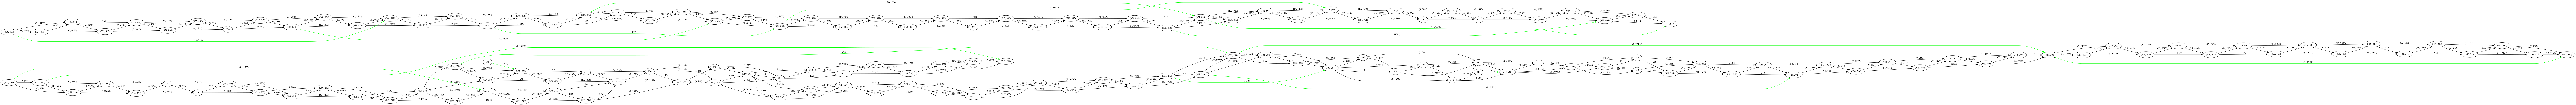

In [104]:
plot_graph(position, dataX)

(120000, 200000)

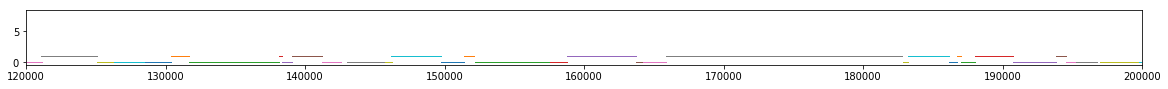

In [106]:
position
#data = read_file('my_apd199.lst','')
pos = sorted(position.items(), key = lambda x: x[1])
contig_len = get_contig_lengths(open('APDContigs.len'))
x_werte = [(contig, start, start+contig_len[contig_name(contig)]) for contig, start in pos]
constraints = {frozenset({a,b}) for a, b, _ in data}
plt.rcParams['figure.figsize'] = 20, 1
y_frei = coll.defaultdict(int)
c, _ = pos[0]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    """if contig[-1] != '0':
        plt.plot([x1,x2],[y,y],linewidth = 1)
       # x1 = x1 + contig_len[contig_name(contig)]/2
        x3 = position3[contig_name(contig) + '_0'] #+ contig_len[contig_name(contig)]/2
      #  plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
        if x1 > x3:
            x1,x3 = x3,x1
        plt.plot([x1,x3],[0,1])#, color = 'r')
    else:"""
    plt.plot([x1,x2],[y,y],linewidth = 4)#, color = 'b')
    y_frei[y] = x2
    
#plt.xlim([120000,200000])

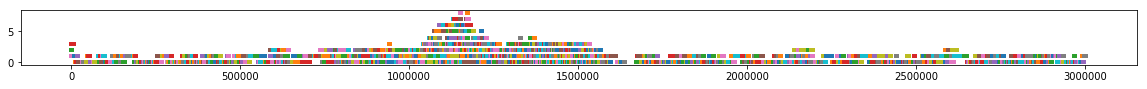

In [108]:
y_frei = coll.defaultdict(int)
c, _ = pos[0]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    plt.plot([x1,x2],[y,y],linewidth = 4)#, color = 'b')
    y_frei[y] = x2

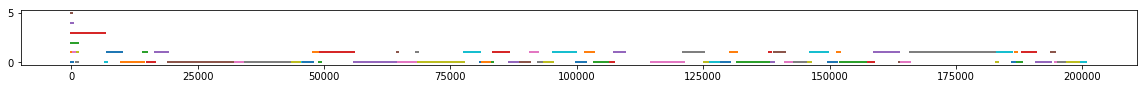

In [110]:
y_frei = coll.defaultdict(int)
c, _ = pos[0]
for contig, x1, x2 in x_werte:
    if x1>200000:
        break
    y = 0
    while y_frei[y] > x1:
        y += 1
    plt.plot([x1,x2],[y,y],linewidth = 2)#, color = 'b')
    y_frei[y] = x2

In [112]:
for c, G in gruppen.items():
    for g in G:
        print(c,g)

{'356APD': [Repeat(pos=2105267.0, güte=402.88983378795604, güte_0=463.5307962470813, stärke=205, gewicht=10, in_out=True, genauigkeit=0.5916191459426855)],
 '1932APD': [Repeat(pos=3382282.0, güte=0, güte_0=24.053751801292652, stärke=13, gewicht=2, in_out=True, genauigkeit=1.2335257333996232)],
 '920APD': [Repeat(pos=2239490.0, güte=349.51998626467173, güte_0=396.74680427648525, stärke=117, gewicht=13, in_out=True, genauigkeit=0.8072960343899745)],
 '1963APD': [Repeat(pos=4648620.0, güte=172.8310219145897, güte_0=206.2611049170265, stärke=72, gewicht=6, in_out=True, genauigkeit=0.9286134167343557)],
 '744APD': [Repeat(pos=2859964.0, güte=218.8816886456607, güte_0=247.6262755211299, stärke=91, gewicht=14, in_out=True, genauigkeit=0.6317491620982257),
  Repeat(pos=2954129.0, güte=284.1354264674821, güte_0=325.20220531877294, stärke=131, gewicht=11, in_out=True, genauigkeit=0.626973722920471)],
 '1358APD': [Repeat(pos=1913497.0, güte=473.0926638240459, güte_0=527.8243314313452, stärke=116,

In [ ]:
position = Lösung2
#data = read_file('my_apd199.lst','')
pos = sorted(position.items(), key = lambda x: x[1])
contig_len = get_contig_lengths(open('APDContigs.len'))
x_werte = [(contig, start, start+contig_len[contig_name(contig)]) for contig, start in pos]
#constraints = {frozenset({a,b}) for a, b, _ in data}
plt.rcParams['figure.figsize'] = 20, 1
y_frei = coll.defaultdict(int)
c, _ = pos[0]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    """if contig[-1] != '0':
        plt.plot([x1,x2],[y,y],linewidth = 1)
       # x1 = x1 + contig_len[contig_name(contig)]/2
        x3 = position3[contig_name(contig) + '_0'] #+ contig_len[contig_name(contig)]/2
      #  plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
        if x1 > x3:
            x1,x3 = x3,x1
        plt.plot([x1,x3],[0,1])#, color = 'r')
    else:"""
    plt.plot([x1,x2],[y,y],linewidth = 4)#, color = 'b')
    y_frei[y] = x2
    
#plt.xlim([120000,200000])